# 04 - The Unreasonable Effectiveness of Linear Regression
 
 
## All You Need is Linear Regression
 
 
### Why We Need Models
 


## what did I learned


At first, when I ran a simple regression between credit limit and default rate, the relationship looked really strong — people with higher credit limits seemed much less likely to default. But that turned out to be misleading.

Why? Because things like income and credit score also influence both the credit limit and the likelihood of default. So what I was really seeing wasn’t the true effect of the limit — it was the effect of those underlying factors.

Then I used a debiasing step, basically removing the part of the credit limit that can be explained by income and credit scores. Once I did that, the relationship between limit and default almost disappeared. That means most of the negative correlation we saw before was actually due to those confounding factors.

Next, I went one step further and denoised the default rate — meaning I also took out the part of default that’s explained by those same variables. After that, the relationship actually flipped a bit — it became slightly positive. In other words, once we control for risk, giving people a higher limit might even make them a bit more likely to default.

So overall, the takeaway is:

what looked like a clear “higher limit, lower default” story was really just confounding.
After adjusting for income and credit scores, the causal effect of credit limit on default is basically flat — or even slightly positive.

And that’s the power of regression — it doesn’t just predict; it helps us uncover what’s really driving the relationship.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)



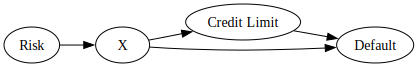

In [7]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

### Regression in A/B Tests


In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [11]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


In [13]:
(data
 .groupby("recommender")
 ["watch_time"]
 .mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

### Adjusting with Regression


In [16]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [18]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


Text(0.5, 1.0, 'Default Rate by Credit Limit')

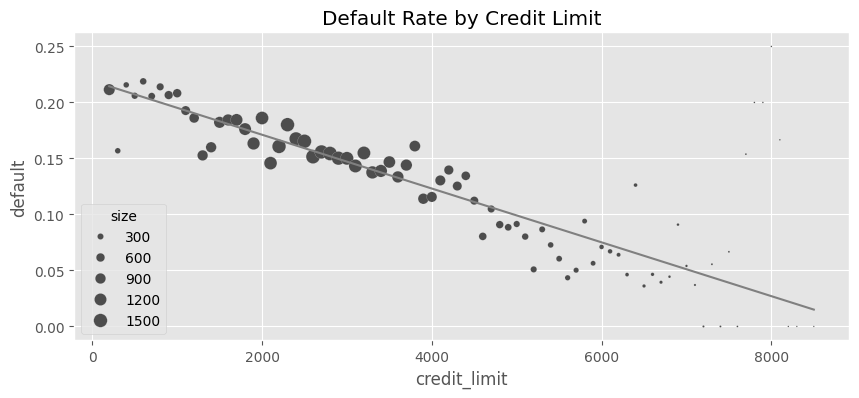

In [20]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")


In [22]:
risk_data.groupby(["credit_score1", "credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [24]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


## Regression Theory


In [26]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

 
### Single Variable Linear Regression


### Multivariate Linear Regression


## Frisch-Waugh-Lovell Theorem and Orthogonalization


In [28]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


### Debiasing Step


Text(0.5, 1.0, 'Default Rate by Credit Limit')

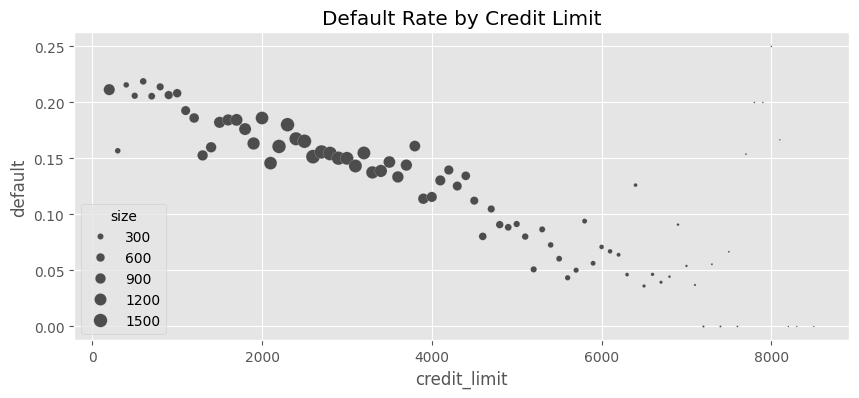

In [30]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")


In [32]:
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals
    credit_limit_res=(debiasing_model.resid 
                      + risk_data["credit_limit"].mean())
)

In [34]:
model_w_deb_data = smf.ols('default ~ credit_limit_res',
                           data=risk_data_deb).fit()

model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

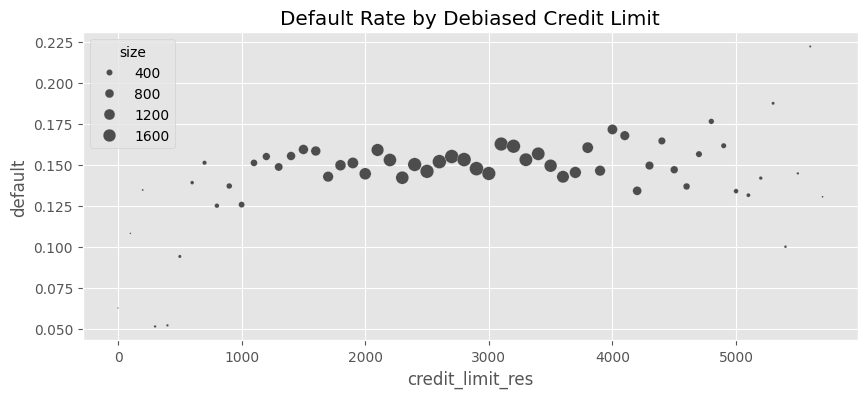

In [36]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")


### Denoising Step


In [39]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data_deb
).fit()

risk_data_denoise = risk_data_deb.assign(
    default_res=denoising_model.resid + risk_data_deb["default"].mean()
)

### Standard Error of the Regression Estimator

In [41]:
model_se = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

print("SE regression:", model_se.bse["wage"])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data=risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid)
              /(np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula:   ", se_formula)

SE regression: 5.364242347548243e-06
SE formula:    5.3642423475482e-06


### Final Outcome Model


In [43]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data=risk_data_denoise).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

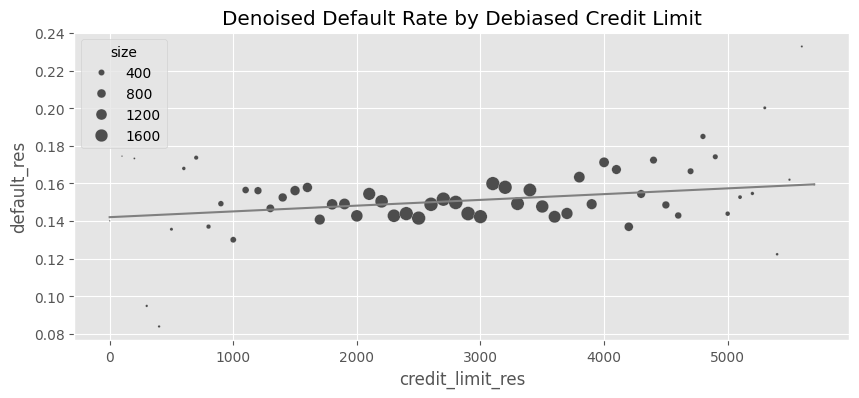

In [45]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")



### FWL Summary


## Regression as an Outcome Model


## Positivity and Extrapolation


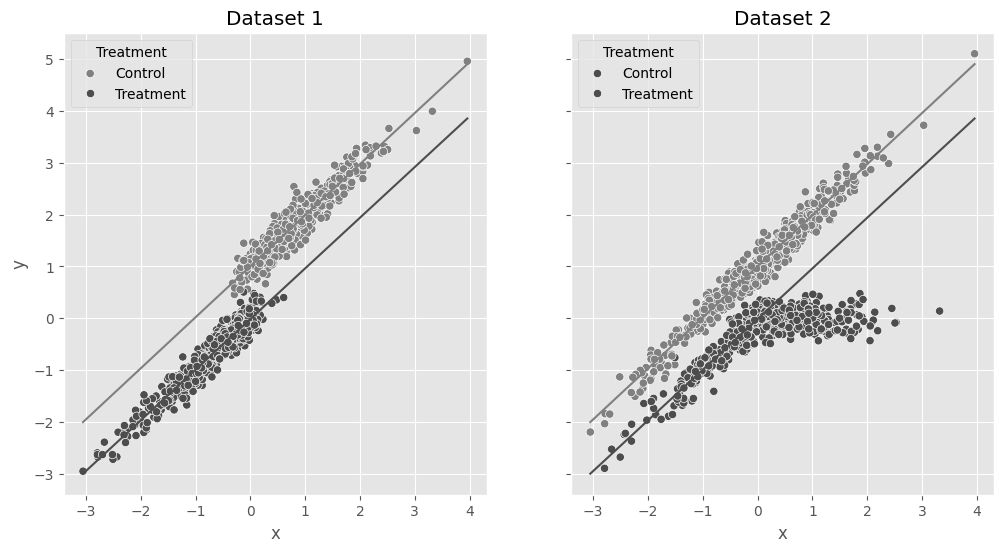

In [50]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1)

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")
ax1.legend(title="Treatment", labels=["Control", "Treatment"])

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2)

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")
ax2.legend(title="Treatment", labels=["Control", "Treatment"])



## Non-Linearities in Linear Regression


In [53]:
spend_data = pd.read_csv("./data/spend_data.csv")

spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


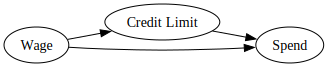

In [55]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

<Axes: xlabel='credit_limit', ylabel='spend'>

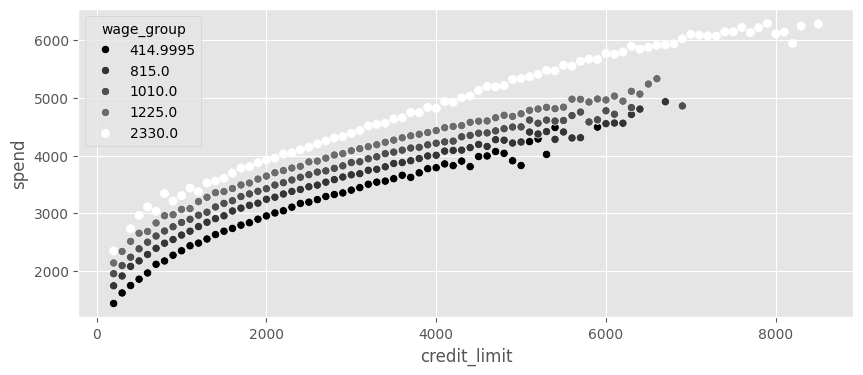

In [57]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")


![img](./data/img/code-img/04-img8.png)

Rather, the treatment response curve seems to have some sort of concavity to it: the higher the credit limit, the lower the slope of this curve. Or, in causal inference language, since slopes and causal effects are intimately related, you can also say that the effect of lines on spend diminishes as you increase lines: going from a line of 1000 to 2000 increases spend more than going from 2000 to 3000. 
 
### Linearizing the Treatment
 
To deal with that, you first need to transform the treatment into something that does have a linear relationship with the outcome. For instance, you know that the relationship seems concave, so you can try to apply some concave function to lines. Some good candidates to try out are the Log function, the square root function or any function that takes credit lines to the power of a fraction. 
 
In this case, let's try the square root:

<Axes: xlabel='credit_limit_sqrt', ylabel='spend'>

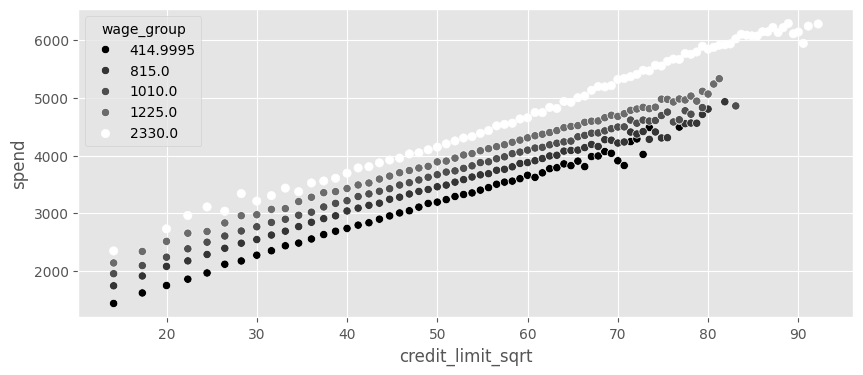

In [60]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")


In [62]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)',data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


<Axes: xlabel='credit_limit', ylabel='spend'>

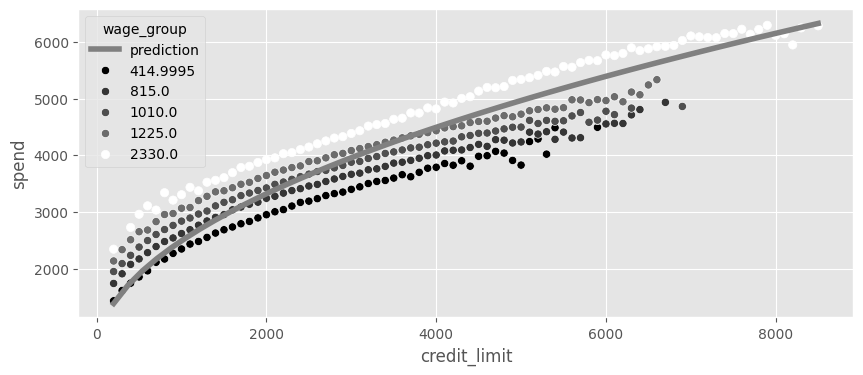

In [64]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")



In [66]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit)+wage',
                      data=spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### Non-Linear FWL and Debiasing


In [69]:
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage',
                             data=spend_data).fit()
denoise_spend_model = smf.ols(f'spend ~ wage', data=spend_data).fit()


credit_limit_sqrt_deb = (debias_spend_model.resid 
                         + np.sqrt(spend_data["credit_limit"]).mean())
spend_den = denoise_spend_model.resid + spend_data["spend"].mean()


spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


<Axes: xlabel='credit_limit', ylabel='spend'>

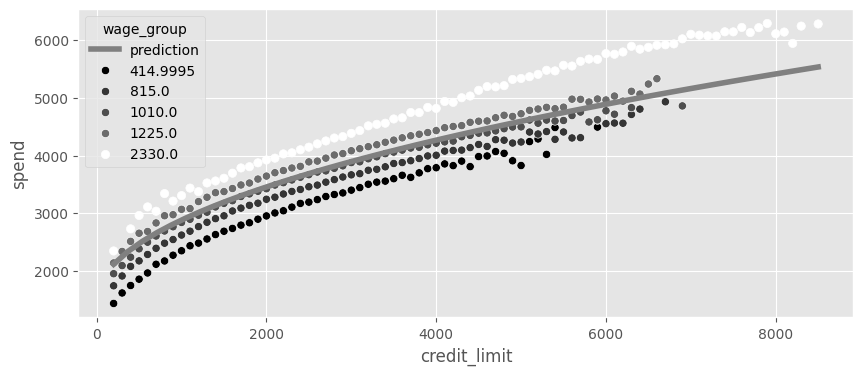

In [71]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] 
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")


## Regression for Dummies
 
### Conditionally Random Experiments


In [74]:
risk_data_rnd = pd.read_csv("./data/risk_data_rnd.csv")
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

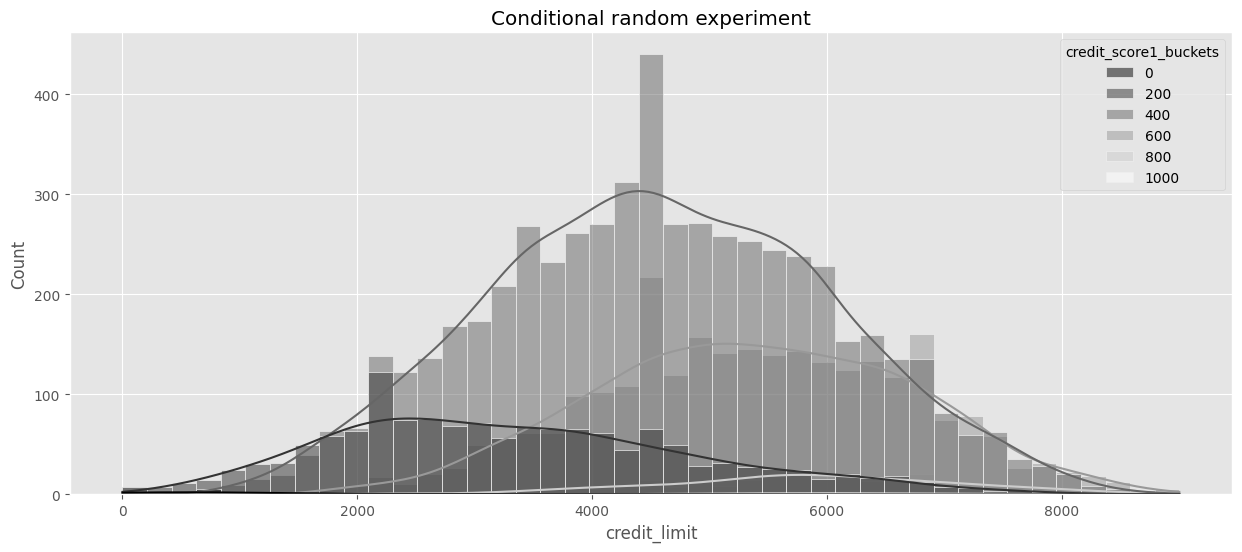

In [76]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")

### Dummy Variables
 


In [79]:
model = smf.ols("default ~ credit_limit", data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [81]:
pd.set_option('display.max_columns', 9)

In [83]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix="sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,True,False,False,False
1,670.0,11,7,1,...,False,False,False,False
2,1220.0,14,9,1,...,True,False,False,False
3,1210.0,15,8,1,...,False,True,False,False
4,900.0,16,1,1,...,False,False,False,False


In [85]:
model = smf.ols(
    "default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000",
    data=risk_data_dummies
).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
sb_200[T.True],-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400[T.True],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600[T.True],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800[T.True],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000[T.True],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


In [87]:
model = smf.ols("default ~ credit_limit + C(credit_score1_buckets)",
                data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


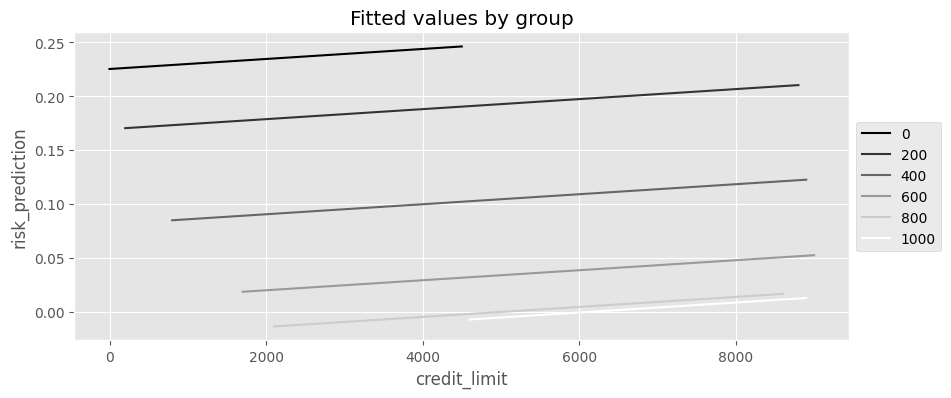

In [89]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### Saturated Regression Model


In [92]:
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [94]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748682e-06

In [96]:
model = smf.ols("default ~ credit_limit * C(credit_score1_buckets)",
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [98]:
(model.params[model.params.index.str.contains("credit_limit:")]
 + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]   -0.000000
dtype: float64

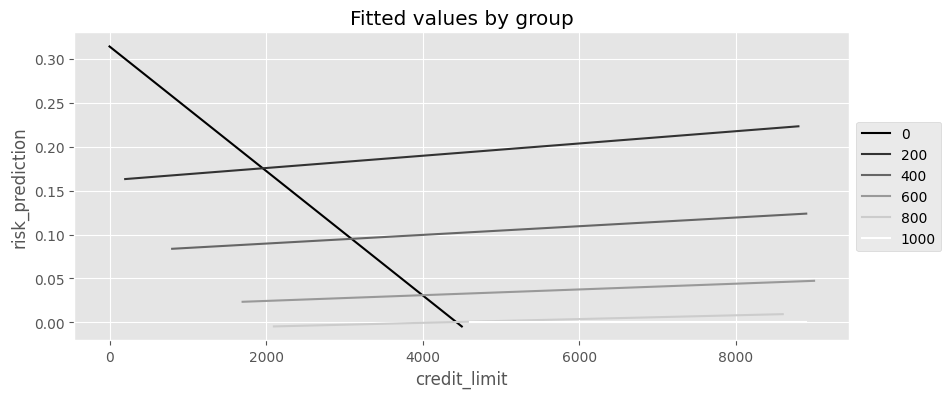

In [100]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Regression as Variance Weighted Average


In [103]:
np.random.seed(123)

# std(t)=1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1, # ATE of 1
    g=1,
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2,
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [105]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.3333333333333324

In [107]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

### De-Meaning and Fixed Effects


In [110]:
model_deb = smf.ols("credit_limit ~ C(credit_score1_buckets)",
                    data=risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [112]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [114]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [116]:
model = smf.ols("default ~ I(credit_limit-credit_limit_avg)",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [118]:
model = smf.ols("default ~ credit_limit + credit_limit_avg",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


## Omitted Variable Bias: Confounding Through the Lens of Regression


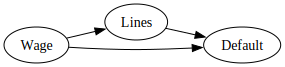

In [121]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

In [123]:
short_model = smf.ols("default ~ credit_limit", data=risk_data).fit()
short_model.params["credit_limit"]

-2.4019619925970212e-05

In [125]:
long_model = smf.ols("default ~ credit_limit + wage",
                     data=risk_data).fit()

omitted_model = smf.ols("wage ~ credit_limit", data=risk_data).fit()

(long_model.params["credit_limit"] 
 + long_model.params["wage"]*omitted_model.params["credit_limit"])

-2.401961992597026e-05

## Neutral Controls


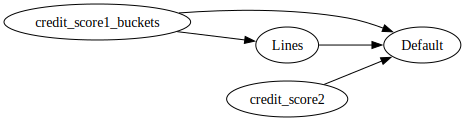

In [128]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

In [130]:
formula = "default~credit_limit+C(credit_score1_buckets)+credit_score2"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


### Noise Inducing Control


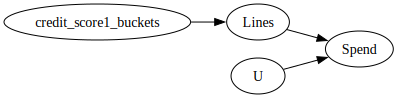

In [133]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

In [135]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

model = smf.ols("spend ~ np.sqrt(credit_limit)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [137]:
model = smf.ols("spend~np.sqrt(credit_limit)+C(credit_score1_buckets)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


### Feature Selection: A Bias-Variance Trade-Off


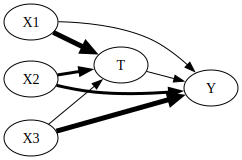

In [140]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})


g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

In [142]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [144]:
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## Key Ideas


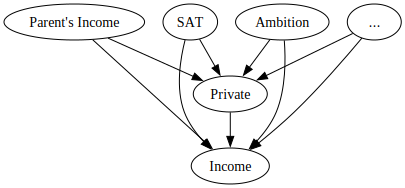

In [147]:
import graphviz as gr

g = gr.Digraph(format="png")

g.edge("Parent's Income", "Private")
g.edge("SAT", "Private")
g.edge("Ambition", "Private")
g.edge("...", "Private")

g.edge("Parent's Income", "Income")
g.edge("SAT", "Income")
g.edge("Ambition", "Income")
g.edge("...", "Income")

g.edge("Private", "Income")

g